In [1]:
import os
import pandas as pd
import requests
import time
import json
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt

from pygam import LinearGAM, s
from sklearn.metrics import mean_squared_error

In [31]:
API_KEY = "YwnbHRjcJvf6Md2OPoKbSRGHlzZ7hjR6"
url     = f"https://financialmodelingprep.com/api/v3/sp500_constituent?apikey={API_KEY}"

# Fetch JSON and load directly into pandas
data = requests.get(url).json()
df   = pd.DataFrame(data)

print(df.shape)   
df.shape
df.columns


(503, 8)


Index(['symbol', 'name', 'sector', 'subSector', 'headQuarter',
       'dateFirstAdded', 'cik', 'founded'],
      dtype='object')

In [20]:
# Set up data folder and file paths
data_folder = os.path.join(os.path.expanduser("~/Desktop/Trading"), "Data")
csv_file = os.path.join(data_folder, "spy_tickers_sample.csv")
json_file = os.path.join(data_folder, "income_statements.json")

# Define which fields to keep
desired_fields = [
    'symbol',
    'date',
    'revenue',
    'grossProfit',
    'operatingIncome',
    'netIncome',
    'eps',
    'ebitda',
    'costOfRevenue',
    'operatingExpenses'
]

# Try loading from cached JSON if it exists
if os.path.exists(json_file):
    print("Loading data from JSON cache...")
    with open(json_file, 'r') as f:
        records = json.load(f)
else:
    # Load tickers
    df = pd.read_csv(csv_file)
    tickers = df['Ticker'].dropna().tolist()

    API_KEY = 'YwnbHRjcJvf6Md2OPoKbSRGHlzZ7hjR6'
    records = []

    # Fetch most recent income statement per ticker
    for ticker in tickers:
        url = f'https://financialmodelingprep.com/api/v3/income-statement/{ticker}?limit=1&apikey={API_KEY}'
        try:
            response = requests.get(url)
            response.raise_for_status()
            data = response.json()
            if data:
                row = data[0]
                row['symbol'] = ticker
                filtered_row = {k: row.get(k, None) for k in desired_fields}
                records.append(filtered_row)
        except requests.exceptions.RequestException as e:
            print(f"Error fetching {ticker}: {e}")
        time.sleep(1)  # Rate limiting

    # Save to JSON
    with open(json_file, 'w') as f:
        json.dump(records, f, indent=2)
    print("Saved data to JSON cache.")

# Convert to DataFrame
income_df = pd.DataFrame(records)

# Show sample
print(income_df.shape)
print(income_df.columns)


Loading data from JSON cache...
(100, 38)
Index(['date', 'symbol', 'reportedCurrency', 'cik', 'fillingDate',
       'acceptedDate', 'calendarYear', 'period', 'revenue', 'costOfRevenue',
       'grossProfit', 'grossProfitRatio', 'researchAndDevelopmentExpenses',
       'generalAndAdministrativeExpenses', 'sellingAndMarketingExpenses',
       'sellingGeneralAndAdministrativeExpenses', 'otherExpenses',
       'operatingExpenses', 'costAndExpenses', 'interestIncome',
       'interestExpense', 'depreciationAndAmortization', 'ebitda',
       'ebitdaratio', 'operatingIncome', 'operatingIncomeRatio',
       'totalOtherIncomeExpensesNet', 'incomeBeforeTax',
       'incomeBeforeTaxRatio', 'incomeTaxExpense', 'netIncome',
       'netIncomeRatio', 'eps', 'epsdiluted', 'weightedAverageShsOut',
       'weightedAverageShsOutDil', 'link', 'finalLink'],
      dtype='object')


In [23]:
# Paths
data_folder  = os.path.join(os.path.expanduser("~/Desktop/Trading"), "Data")
csv_file     = os.path.join(data_folder, "spy_tickers_sample.csv")
output_file  = os.path.join(data_folder, "income_growth.json")

# API setup
API_KEY  = "YwnbHRjcJvf6Md2OPoKbSRGHlzZ7hjR6"
BASE_URL = "https://financialmodelingprep.com/stable/income-statement-growth"

# Try loading from cache
if os.path.exists(output_file):
    print("Loading growth data from JSON cache...")
    with open(output_file, "r") as f:
        growth_records = json.load(f)

else:
    print("No cache found — fetching growth data from API...")
    # Load tickers
    df       = pd.read_csv(csv_file)
    tickers  = df['Ticker'].tolist()
    growth_records = []

    # Fetch and flatten all periods (Solution B)
    for ticker in tickers:
        url = f"{BASE_URL}?symbol={ticker}&apikey={API_KEY}"
        try:
            resp = requests.get(url)
            resp.raise_for_status()
            data = resp.json()

            if isinstance(data, list) and data:
                for period in data:
                    period['symbol'] = ticker
                    growth_records.append(period)
            else:
                print(f"  • no growth data for {ticker}")

        except requests.exceptions.RequestException as e:
            print(f"Error fetching {ticker}: {e}")

        time.sleep(1)  # respect rate limits

    # Save to JSON cache
    os.makedirs(data_folder, exist_ok=True)
    with open(output_file, "w") as f:
        json.dump(growth_records, f, indent=2)
    print(f"Saved {len(growth_records)} records to JSON cache.")

# Convert to DataFrame and inspect
df_growth = pd.DataFrame(growth_records)
print(df_growth.shape)
print("Columns in growth DataFrame:", df_growth.columns)


Loading growth data from JSON cache...
(100, 34)
Columns in growth DataFrame: Index(['symbol', 'date', 'fiscalYear', 'period', 'reportedCurrency',
       'growthRevenue', 'growthCostOfRevenue', 'growthGrossProfit',
       'growthGrossProfitRatio', 'growthResearchAndDevelopmentExpenses',
       'growthGeneralAndAdministrativeExpenses',
       'growthSellingAndMarketingExpenses', 'growthOtherExpenses',
       'growthOperatingExpenses', 'growthCostAndExpenses',
       'growthInterestIncome', 'growthInterestExpense',
       'growthDepreciationAndAmortization', 'growthEBITDA',
       'growthOperatingIncome', 'growthIncomeBeforeTax',
       'growthIncomeTaxExpense', 'growthNetIncome', 'growthEPS',
       'growthEPSDiluted', 'growthWeightedAverageShsOut',
       'growthWeightedAverageShsOutDil', 'growthEBIT',
       'growthNonOperatingIncomeExcludingInterest', 'growthNetInterestIncome',
       'growthTotalOtherIncomeExpensesNet',
       'growthNetIncomeFromContinuingOperations',
       'growt

In [26]:
# Define paths
data_folder = os.path.join(os.path.expanduser("~/Desktop/Trading"), "Data")
tickers_csv_path = os.path.join(data_folder, "spy_tickers_sample.csv")
output_json_path = os.path.join(data_folder, "ratios.json")

# Try loading from cache
if os.path.exists(output_json_path):
    print("Loading ratios from JSON cache...")
    with open(output_json_path, "r") as f:
        all_ratios = json.load(f)
else:
    print("No cache found — fetching ratios from API...")
    tickers_df = pd.read_csv(tickers_csv_path)
    tickers = tickers_df['Ticker'].dropna().unique().tolist()

    api_key = "YwnbHRjcJvf6Md2OPoKbSRGHlzZ7hjR6"
    base_url = "https://financialmodelingprep.com/api/v3/ratios/{}?limit=1&apikey={}"

    all_ratios = []

    for ticker in tickers:
        try:
            url = base_url.format(ticker, api_key)
            response = requests.get(url)
            response.raise_for_status()
            data = response.json()
            if data:
                all_ratios.append(data[0])
            time.sleep(1)
        except Exception as e:
            print(f"Error fetching {ticker}: {e}")

    # Save to cache
    with open(output_json_path, "w") as f:
        json.dump(all_ratios, f, indent=2)
    print(f"Saved {len(all_ratios)} records to JSON cache.")

# Convert to DataFrame
df_ratios = pd.DataFrame(all_ratios)
print(df_ratios.columns)
print(df_ratios.shape)

Loading ratios from JSON cache...
Index(['symbol', 'date', 'calendarYear', 'period', 'currentRatio',
       'quickRatio', 'cashRatio', 'daysOfSalesOutstanding',
       'daysOfInventoryOutstanding', 'operatingCycle',
       'daysOfPayablesOutstanding', 'cashConversionCycle', 'grossProfitMargin',
       'operatingProfitMargin', 'pretaxProfitMargin', 'netProfitMargin',
       'effectiveTaxRate', 'returnOnAssets', 'returnOnEquity',
       'returnOnCapitalEmployed', 'netIncomePerEBT', 'ebtPerEbit',
       'ebitPerRevenue', 'debtRatio', 'debtEquityRatio',
       'longTermDebtToCapitalization', 'totalDebtToCapitalization',
       'interestCoverage', 'cashFlowToDebtRatio', 'companyEquityMultiplier',
       'receivablesTurnover', 'payablesTurnover', 'inventoryTurnover',
       'fixedAssetTurnover', 'assetTurnover', 'operatingCashFlowPerShare',
       'freeCashFlowPerShare', 'cashPerShare', 'payoutRatio',
       'operatingCashFlowSalesRatio', 'freeCashFlowOperatingCashFlowRatio',
       'cashFlo

In [27]:
# 1. Set up paths
data_folder = os.path.join(os.path.expanduser("~/Desktop/Trading"), "Data")
csv_file    = os.path.join(data_folder, "spy_tickers_sample.csv")
json_file   = os.path.join(data_folder, "company_info.json")

# 2. Define the fields you want to keep
desired_fields = [
    "symbol", "companyName", "marketCap", "sector", "industry", "beta",
    "price", "lastAnnualDividend", "volume", "exchange", "exchangeShortName",
    "country", "isEtf", "isFund"
]

# 3. Load or fetch company info
records = []

if os.path.exists(json_file):
    print("Loading company info from JSON cache...")
    with open(json_file, "r") as f:
        records = json.load(f)

else:
    print("No cache found — fetching company info from API...")
    df      = pd.read_csv(csv_file)
    tickers = df['Ticker'].dropna().unique().tolist()
    print(f"Found {len(tickers)} unique tickers.")

    API_KEY  = "YwnbHRjcJvf6Md2OPoKbSRGHlzZ7hjR6"
    BASE_URL = "https://financialmodelingprep.com/api/v3/profile/{}?apikey={}"

    failed = []

    for i, ticker in enumerate(tickers, 1):
        url = BASE_URL.format(ticker, API_KEY)
        try:
            resp = requests.get(url)
            resp.raise_for_status()
            data = resp.json()
            if isinstance(data, list) and data:
                row = data[0]
                filtered = {k: row.get(k, None) for k in desired_fields}
                records.append(filtered)
            else:
                print(f"  • No profile data for {ticker}")
                failed.append(ticker)
        except requests.exceptions.RequestException as e:
            print(f"Error fetching {ticker}: {e}")
            failed.append(ticker)
        time.sleep(1)

    os.makedirs(data_folder, exist_ok=True)
    with open(json_file, "w") as f:
        json.dump(records, f, indent=2)
    print(f"Saved {len(records)} company records to cache.")
    if failed:
        print(f"{len(failed)} tickers failed to fetch: {failed[:5]}...")

# 4. Convert to DataFrame and inspect
company_df = pd.DataFrame(records)
company_df.drop_duplicates(subset="symbol", inplace=True)

print("Columns returned:", company_df.columns.tolist())
print(company_df.columns)
print(company_df.shape)


Loading company info from JSON cache...
Columns returned: ['symbol', 'companyName', 'marketCap', 'sector', 'industry', 'beta', 'price', 'lastAnnualDividend', 'volume', 'exchange', 'exchangeShortName', 'country', 'isEtf', 'isFund']
Index(['symbol', 'companyName', 'marketCap', 'sector', 'industry', 'beta',
       'price', 'lastAnnualDividend', 'volume', 'exchange',
       'exchangeShortName', 'country', 'isEtf', 'isFund'],
      dtype='object')
(100, 14)


In [14]:
## --- PREP DATA ---
# Convert to numeric
df_ratios['priceEarningsRatio'] = pd.to_numeric(df_ratios['priceEarningsRatio'], errors='coerce')
df_growth['growthEPSDiluted'] = pd.to_numeric(df_growth['growthEPSDiluted'], errors='coerce')

# Merge
merged_df = pd.merge(
    df_ratios[['symbol', 'priceEarningsRatio']],
    df_growth[['symbol', 'growthEPSDiluted']],
    on='symbol',
    how='inner'
)

# Drop missing values
reg_df = merged_df.dropna(subset=['priceEarningsRatio', 'growthEPSDiluted']).copy()

# Filter out non-positive values
reg_df = reg_df[(reg_df['growthEPSDiluted'] > 0) & (reg_df['priceEarningsRatio'] > 0)]

# Log-transform P/E
reg_df['ln_PE'] = np.log(reg_df['priceEarningsRatio'])

# --- RUN REGRESSIONS AT DIFFERENT CAPS ---
results_table = []

for cap in np.arange(0.05, 1.05, 0.05):  # 5% increments
    temp_df = reg_df[reg_df['growthEPSDiluted'] <= cap]
    if len(temp_df) < 5:  # skip if not enough data
        continue
    
    X = sm.add_constant(temp_df['growthEPSDiluted'])
    y = temp_df['ln_PE']
    model = sm.OLS(y, X).fit()
    
    results_table.append({
        'cap': cap,
        'r2': model.rsquared,
        't_stat': model.tvalues['growthEPSDiluted'],
        'mse': mean_squared_error(y, model.fittedvalues),
        'model': model
    })

# Convert to DataFrame
results_df = pd.DataFrame(results_table).sort_values('mse')

# --- PRINT RESULTS ---
print(results_df[['cap', 'r2', 't_stat', 'mse']])

best_model_row = results_df.iloc[0]
print("\nBest growth cap:", best_model_row['cap'])
print(best_model_row['model'].summary())


     cap        r2    t_stat       mse
1   0.10  0.153365  1.592500  0.109243
2   0.15  0.011109  0.449678  0.124304
3   0.20  0.050483  1.175736  0.155833
4   0.25  0.068722  1.536677  0.170712
5   0.30  0.155540  2.539018  0.179484
6   0.35  0.078285  1.772727  0.190167
7   0.40  0.032998  1.153616  0.191746
0   0.05  0.079820  0.510128  0.211940
8   0.45  0.000044  0.041964  0.223262
14  0.75  0.017298  0.928726  0.227692
13  0.70  0.017298  0.928726  0.227692
12  0.65  0.017298  0.928726  0.227692
9   0.50  0.005154 -0.466451  0.227761
11  0.60  0.007706  0.604136  0.232494
15  0.80  0.002252  0.335960  0.234261
16  0.85  0.002252  0.335960  0.234261
10  0.55  0.004004  0.430022  0.236610
18  0.95  0.058587  1.798922  0.260866
19  1.00  0.058587  1.798922  0.260866
17  0.90  0.047272  1.590749  0.265723

Best growth cap: 0.1
                            OLS Regression Results                            
Dep. Variable:                  ln_PE   R-squared:                       0.153
M

/Users/nicholassanso/anaconda3/envs/dsi/lib/python3.8/site-packages/scipy/stats/_stats_py.py:1736: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=16
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


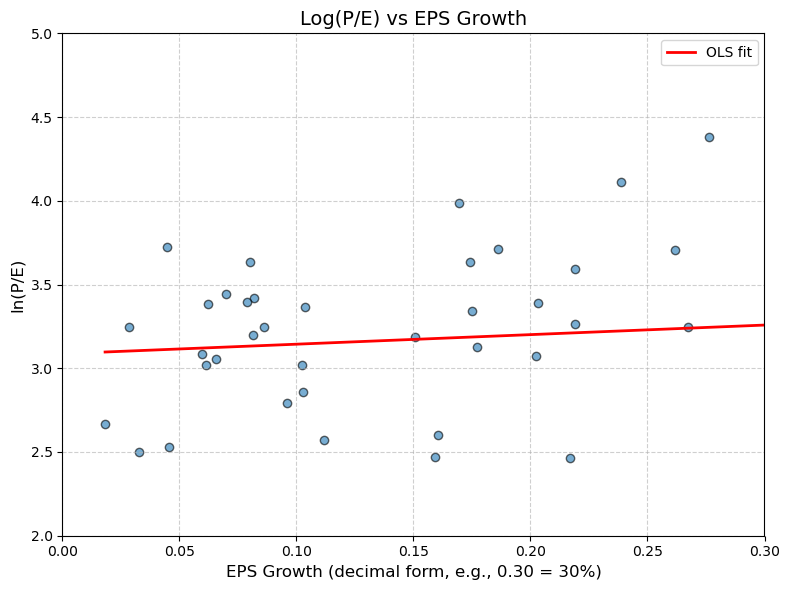

In [17]:
# Scatterplot
plt.figure(figsize=(8,6))
plt.scatter(reg_df['growthEPSDiluted'], reg_df['ln_PE'], alpha=0.6, edgecolors='k')

# Regression line
x_vals = np.linspace(reg_df['growthEPSDiluted'].min(), reg_df['growthEPSDiluted'].max(), 5)
plt.xlim(0, .3)
y_vals = model.params['const'] + model.params['growthEPSDiluted'] * x_vals
plt.ylim(2, 5)

plt.plot(x_vals, y_vals, color='red', linewidth=2, label='OLS fit')

# Labels & title
plt.xlabel("EPS Growth (decimal form, e.g., 0.30 = 30%)", fontsize=12)
plt.ylabel("ln(P/E)", fontsize=12)
plt.title("Log(P/E) vs EPS Growth", fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()


In [18]:
import statsmodels.formula.api as smf

# Non‐linear threshold model: allow different slopes below/above gamma
def threshold_model(gamma):
    reg_df['below'] = (reg_df['growthEPSDiluted'] <= gamma) * reg_df['growthEPSDiluted']
    reg_df['above'] = (reg_df['growthEPSDiluted'] > gamma) * reg_df['growthEPSDiluted']
    formula = 'ln_PE ~ below + above'
    return smf.ols(formula, data=reg_df).fit()

# Grid‐search gamma in [0.05,1.0]
gammas, rss = [], []
for g in np.linspace(0.05, 1, 20):
    fit = threshold_model(g)
    gammas.append(g); rss.append(sum(fit.resid**2))

best_gamma = gammas[np.argmin(rss)]
best_model   = threshold_model(best_gamma)
